In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dat = xr.open_dataset('C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/Bellamite_538_R.nc')

In [3]:
display(dat)

<xarray.Dataset> Size: 65MB
Dimensions:                                   (N_MEASUREMENTS: 415541,
                                               N_PARAM: 16)
Dimensions without coordinates: N_MEASUREMENTS, N_PARAM
Data variables: (12/51)
    TIME                                      (N_MEASUREMENTS) datetime64[ns] 3MB ...
    TIME_GPS                                  (N_MEASUREMENTS) datetime64[ns] 3MB ...
    PHASE                                     (N_MEASUREMENTS) float32 2MB ...
    PHASE_QC                                  (N_MEASUREMENTS) float32 2MB ...
    LATITUDE_GPS                              (N_MEASUREMENTS) float32 2MB ...
    LONGITUDE_GPS                             (N_MEASUREMENTS) float32 2MB ...
    ...                                        ...
    PLATFORM_TYPE                             <U6 24B ...
    PLATFORM_MODEL                            <U2 8B ...
    WMO_IDENTIFIER                            <U3 12B ...
    DEPLOYMENT_TIME                           datetime64[ns] 8B ...
    DEPLOYMENT_LATITUDE                       <U3 12B ...
    DEPLOYMENT_LONGITUDE                      <U3 12B ...
Attributes: (12/68)
    geospatial_bounds_crs:           EPSG:4326
    geospatial_bounds_vertical_crs:  EPSG:5831
    geospatial_lat_min:              -54.43104
    geospatial_lat_max:              50.89405
    geospatial_lon_min:              -89.29212
    geospatial_lon_max:              -1.3952867
    ...                              ...
    instrument:                      ['Slocum G1+G2 Glider Navigation data lo...
    metadata_link:                   https://api.linked-systems.uk/api/meta/v...
    trajectory:                      Bellamite_20191206
    date_created:                    2024-04-08T15:08:06.115623
    date_modified:                   2024-04-08T15:08:06.115635
    id:                              Bellamite_20191206T000000_R

In [4]:
df_full = dat[['CHLA', 'PRES', 'BBP700', 'TIME']].to_dataframe()
df = df_full.dropna(subset = ['CHLA', 'PRES', 'BBP700'] ,how = 'all')

df['PRES'] = df['PRES'].interpolate()

C:\Users\flapet\AppData\Local\Temp\ipykernel_23136\3723142933.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PRES'] = df['PRES'].interpolate()


In [5]:
df_full.shape[0]

415541

In [5]:
df.set_index('TIME', inplace=True)

# Profile detection

## Detection of the ascent and descent instant speed of the glider

We will first compute the difference of depth between two points. the distribution of the values will indicate a potential breakpoint indicating of a change in the behaviour of the glider.

In [6]:
# Create an empty list to store profile values
diff_index = []
# Initialize the previous pressure value
prev_pres = 0

# Iterate over rows in the DataFrame
for index, row in df.iterrows():
    pres = row['PRES']
    #Compute the difference of pressure
    diff = pres - prev_pres
    diff_index.append(diff)
    # Update the previous pressure value
    prev_pres = pres

# Add the diff values to the DataFrame
df['diff'] = diff_index

C:\Users\flapet\AppData\Local\Temp\ipykernel_23136\170142407.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff'] = diff_index


C:\Users\flapet\AppData\Local\Temp\ipykernel_23136\3972198052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abs_diff'] = abs(df['diff'])


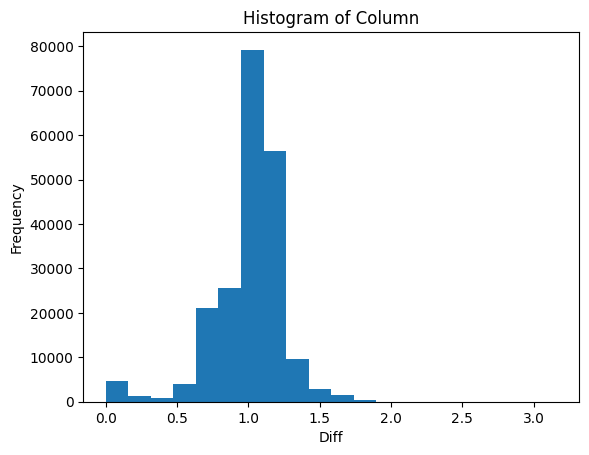

In [7]:
df['abs_diff'] = abs(df['diff'])
plt.hist(df['abs_diff'], bins=20)  # Adjust the number of bins as needed
plt.xlabel('Diff')
plt.ylabel('Frequency')
plt.title('Histogram of Column')
plt.show()

Here, we observe that 0.5 seems to separate two subsample of glider speed. Let's look at the position of the glider when it reaches such position

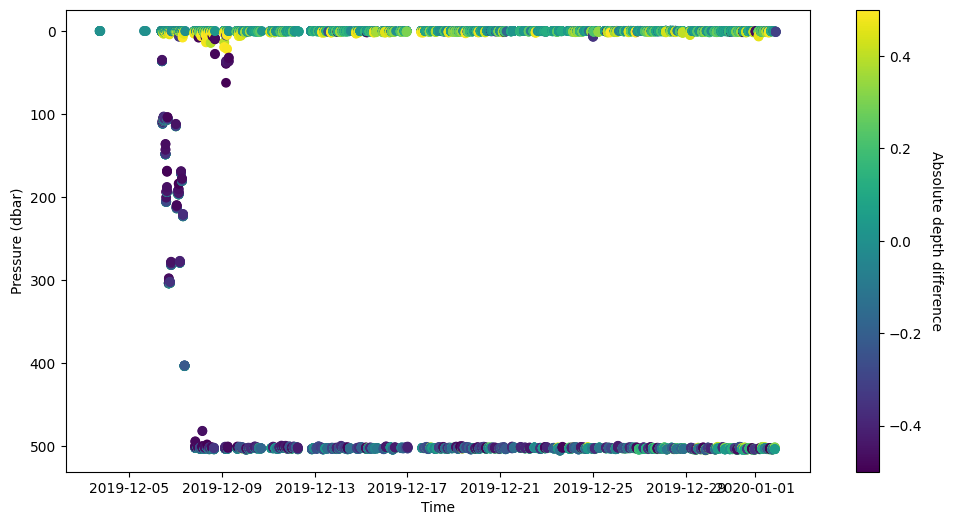

In [9]:
df1 = df[df['abs_diff'] < 0.5]


plt.figure(figsize=(12,6))
plt.scatter(x = df1.index, y = df1['PRES'], c = df1['diff'], cmap = 'viridis')
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time')
cbar = plt.colorbar(label='profile')
cbar.set_label('Absolute depth difference', rotation=270, labelpad=15)

## Profile indexing
We will now compute a simple algorithm that attributes a profile index starting from 1. Every time the glider changes its direction the profile index is incremented by 1.

In [10]:
# Create an initial profile value
profile = 1

# Create an empty list to store profile values
profile_values = []
# Initialize the previous pressure value
prev_way = None

# Iterate over rows in the DataFrame
for index, row in df.iterrows():
    pres = row['PRES']
    diff = row['diff']
    if abs(diff) < 0.5:
        way = 'stationary'
    elif diff < 0:
        way = 'asc'
    else:
        way = 'desc'
    if way == 'stationary':
        profile_values.append(np.nan)
        way = prev_way
    elif prev_way is None or way == prev_way:
        profile_values.append(profile)
    else:
        profile += 1
        profile_values.append(profile)
    # Update the previous way value
    prev_way = way

# Add the profile values to the DataFrame
df['profile'] = profile_values

C:\Users\flapet\AppData\Local\Temp\ipykernel_23136\1370693946.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['profile'] = profile_values


The profile can now be used as the index of the dataframe.

In [11]:
df = df.reset_index().set_index('profile')

We can check the success of the method by looking at the smallest profile and the largest ones.

In [17]:
check = df.index.value_counts()
check

profile
328.0    861
314.0    787
62.0     740
66.0     722
54.0     716
        ... 
5.0      126
6.0      124
3.0      116
1.0       42
2.0       38
Name: count, Length: 444, dtype: int64

In [22]:
stationary = df[np.isnan(df.index)]

In [23]:
stationary.head()

,TIME,CHLA,PRES,BBP700,diff,abs_diff
profile,,,,,,
NaN,2019-12-03 17:23:48.587585024,2.8764,0.000,0.008601,0.000,0.000
NaN,2019-12-03 17:45:25.973479424,3.1008,0.025,0.008601,0.025,0.025
NaN,2019-12-03 17:45:33.096039168,NaN,0.050,NaN,0.025,0.025
NaN,2019-12-03 17:45:36.160187392,3.1144,0.050,0.008601,0.000,0.000
NaN,2019-12-03 17:45:43.209259008,NaN,0.050,NaN,0.000,0.000


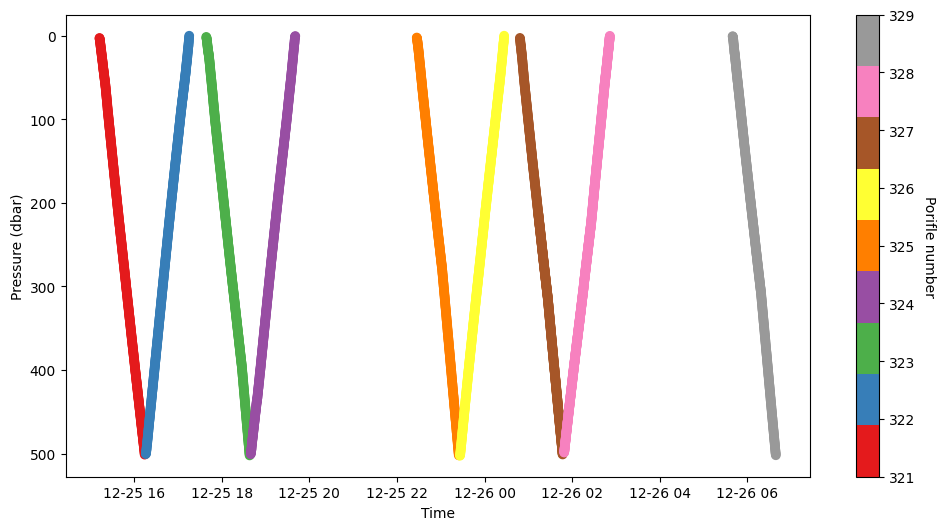

In [18]:
from matplotlib import colormaps
cmap = colormaps['Set1']

df1 = df.loc[321:329]
plt.figure(figsize=(12,6))
plt.scatter(x = df1['TIME'], y = df1['PRES'], c = df1.index, cmap = cmap)
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time')
cbar = plt.colorbar(label='profile')
cbar.set_label('Porifle number', rotation=270, labelpad=15)

In [ ]:
df_full = df_full[df_full['LONGITUDE'] < -88]
plt.figure(figsize=(12,6))
plt.scatter(x = df_full['LONGITUDE'], y = df_full['LATITUDE'], c=df_full['PRES'], cmap='viridis')
cbar = plt.colorbar(label='Index')
cbar.set_label('Pressure (dB)', rotation=270, labelpad=15)